In [1]:
import sqlite3
import pandas as pd
from datetime import datetime

In [2]:
db_path = "results.sca"
conn = sqlite3.connect(db_path)

In [3]:
# Create a dataframe with just the runId and runNames
query = """
SELECT 
    runId,
    attrValue AS runName
FROM runAttr
WHERE attrName = 'configname'
"""

df = pd.read_sql_query(query, conn)

In [4]:
# Add Host Count per run (Wireless)
query = """
SELECT 
    runId,
    paramValue AS wirelessHostCount
FROM runParam
WHERE paramKey = 'WiredAndWirelessHostsWithAP.num_wireless'
  AND paramOrder = 0
ORDER BY runId;
"""

temp = pd.read_sql_query(query, conn)
df = pd.merge(df, temp, on="runId", how="left")

In [5]:
# Add Host Count per run Wired
query = """
SELECT runId, MAX(paramValue) AS wiredHostCount
FROM runParam
WHERE paramKey = 'WiredAndWirelessHostsWithAP.num_wired'
GROUP BY runId
ORDER BY runId;
"""

temp = pd.read_sql_query(query, conn)
df = pd.merge(df, temp, on="runId", how="left")

In [6]:
### PDR ###

# Query to calculate sent and received packets per run
query = """
WITH ReceivedPackets AS (
        SELECT r.runId, s.scalarvalue AS packetReceived
        FROM scalar s JOIN run r ON r.runId = s.runId
        WHERE s.scalarName = 'packetReceived:count' 
        AND s.moduleName = 'WiredAndWirelessHostsWithAP.sinkNode.udp'
    ),
    SentPackets AS (
        SELECT r.runId, SUM(s.scalarvalue) AS packetSent
        FROM scalar s JOIN run r ON r.runId = s.runId
        WHERE s.scalarName = 'packetSent:count' 
        AND s.moduleName LIKE 'WiredAndWirelessHostsWithAP.wirelessHost[%].udp'
        GROUP BY r.runId
    )
    SELECT 
        r.runId,
        COALESCE(sp.packetSent, 0) AS packetsSent,
        COALESCE(rp.packetReceived, 0) AS packetsReceived
    FROM run r
    LEFT JOIN SentPackets sp ON r.runId = sp.runId
    LEFT JOIN ReceivedPackets rp ON r.runId = rp.runId
    ORDER BY r.runId
"""

temp = pd.read_sql_query(query, conn)


In [7]:
df = pd.merge(df, temp, on="runId", how="left")

In [8]:
# Packet Dropped
query = """
SELECT 
    r.runId,
    SUM(s.scalarvalue) AS packetDropped
FROM scalar s
JOIN run r ON r.runId=s.runId
WHERE s.scalarName = 'packetDrop:count'
AND (
        s.moduleName LIKE 'WiredAndWirelessHostsWithAP.wirelessHost[%].wlan[%].mac'
     OR s.moduleName LIKE 'WiredAndWirelessHostsWithAP.accessPoint.wlan[%].mac'
  )
GROUP BY r.runId
"""

temp = pd.read_sql_query(query, conn)
temp.head()

,runId,packetDropped
0,1,542144.0
1,2,114159.0
2,3,278252.0
3,4,416668.0
4,5,1095058.0


In [9]:
df = pd.merge(df, temp, on="runId", how="left")

In [10]:
# Packet Received Sum
query = """
SELECT 
    r.runId,
    SUM(s.scalarvalue) AS packetReceivedByte
FROM scalar s
JOIN run r ON r.runId=s.runId
WHERE s.scalarName = 'packetReceived:sum(packetBytes)'
AND s.moduleName LIKE 'WiredAndWirelessHostsWithAP.sinkNode.udp'
GROUP BY r.runId
"""

temp = pd.read_sql_query(query, conn)
temp.head()

,runId,packetReceivedByte
0,1,9196992.0
1,2,6037920.0
2,3,9055872.0
3,4,9398592.0
4,5,8651664.0


In [11]:
df = pd.merge(df, temp, on="runId", how="left")

In [12]:
# Add simulation time
df["simTime"] = 60
df.loc[df["runName"].str.contains("T3|T4", na=False), "simTime"] = 30

In [13]:
# Mac Frames Transmitted
# Packet Sent to Lower Mac Layer 
query = """
SELECT 
    r.runId,
    SUM(s.scalarvalue) AS macFrameSent
FROM scalar s
JOIN run r ON r.runId=s.runId
WHERE s.scalarName = 'packetSentToLower:count'
AND (
        s.moduleName LIKE 'WiredAndWirelessHostsWithAP.wirelessHost[%].wlan[%].mac'
     OR s.moduleName LIKE 'WiredAndWirelessHostsWithAP.accessPoint.wlan[%].mac'
  )
GROUP BY r.runId
"""

temp = pd.read_sql_query(query, conn)
temp.head()


,runId,macFrameSent
0,1,28031.0
1,2,19950.0
2,3,29680.0
3,4,26855.0
4,5,29526.0


In [14]:
df = pd.merge(df, temp, on="runId", how="left")


In [15]:
# Mac frames Retransmitted

query = """
SELECT 
    r.runId,
    SUM(s.scalarvalue) AS macFrameRetransmitted
FROM scalar s
JOIN run r ON r.runId=s.runId
WHERE s.scalarName = 'packetSentToPeerWithRetry:count' AND (
        s.moduleName LIKE 'WiredAndWirelessHostsWithAP.wirelessHost[%].wlan[%].mac.dcf'
     OR s.moduleName LIKE 'WiredAndWirelessHostsWithAP.accessPoint.wlan[%].mac.dcf'
  )
GROUP BY r.runId
"""

temp = pd.read_sql_query(query, conn)
temp.head()

,runId,macFrameRetransmitted
0,1,7840.0
1,2,7170.0
2,3,10803.0
3,4,7125.0
4,5,10158.0


In [16]:
df = pd.merge(df, temp, on="runId", how="left")

In [17]:
df.head()

,runId,runName,wirelessHostCount,wiredHostCount,packetsSent,packetsReceived,packetDropped,packetReceivedByte,simTime,macFrameSent,macFrameRetransmitted
0,1,T1_A_Hosts_25,25,0,15000.0,9124.0,542144.0,9196992.0,60,28031.0,7840.0
1,2,T1_A_Hosts_10,10,0,6000.0,5990.0,114159.0,6037920.0,60,19950.0,7170.0
2,3,T1_A_Hosts_15,15,0,9000.0,8984.0,278252.0,9055872.0,60,29680.0,10803.0
3,4,T1_A_Hosts_20,20,0,12000.0,9324.0,416668.0,9398592.0,60,26855.0,7125.0
4,5,T1_A_Hosts_50,50,0,30000.0,8583.0,1095058.0,8651664.0,60,29526.0,10158.0


In [18]:
# Packet Dropped due to Queue Overflow

query = """
SELECT 
    r.runId,
    SUM(s.scalarvalue) AS packetDroppedQueueOverflow
FROM scalar s
JOIN run r ON r.runId = s.runId
WHERE s.scalarName = 'packetDropQueueOverflow:count'
  AND (
        s.moduleName LIKE 'WiredAndWirelessHostsWithAP.wirelessHost[%].wlan[%].mac'
     OR s.moduleName LIKE 'WiredAndWirelessHostsWithAP.accessPoint.wlan[%].mac'
  )
GROUP BY r.runId;
"""

temp = pd.read_sql_query(query, conn)
temp.head()

,runId,packetDroppedQueueOverflow
0,1,2422.0
1,2,0.0
2,3,0.0
3,4,1084.0
4,5,14961.0


In [19]:
df = pd.merge(df, temp[["runId", "packetDroppedQueueOverflow"]], on="runId", how="left")

In [20]:
df.head()

,runId,runName,wirelessHostCount,wiredHostCount,packetsSent,packetsReceived,packetDropped,packetReceivedByte,simTime,macFrameSent,macFrameRetransmitted,packetDroppedQueueOverflow
0,1,T1_A_Hosts_25,25,0,15000.0,9124.0,542144.0,9196992.0,60,28031.0,7840.0,2422.0
1,2,T1_A_Hosts_10,10,0,6000.0,5990.0,114159.0,6037920.0,60,19950.0,7170.0,0.0
2,3,T1_A_Hosts_15,15,0,9000.0,8984.0,278252.0,9055872.0,60,29680.0,10803.0,0.0
3,4,T1_A_Hosts_20,20,0,12000.0,9324.0,416668.0,9398592.0,60,26855.0,7125.0,1084.0
4,5,T1_A_Hosts_50,50,0,30000.0,8583.0,1095058.0,8651664.0,60,29526.0,10158.0,14961.0


In [21]:
# --- Approximate BER Calculation ---

# Numerator: total bits in incorrectly received packets
query_ber_num = """
SELECT 
    r.runId,
    SUM(s.scalarvalue) AS erroneousBits
FROM scalar s
JOIN run r ON r.runId = s.runId
WHERE s.scalarName = 'packetDropIncorrectlyReceived:sum(packetBytes)'
  AND (
        s.moduleName LIKE 'WiredAndWirelessHostsWithAP.wirelessHost[%].wlan[%].mac'
     OR s.moduleName LIKE 'WiredAndWirelessHostsWithAP.accessPoint.wlan[%].mac'
  )
GROUP BY r.runId
"""

df_ber_num = pd.read_sql_query(query_ber_num, conn)
# Multiply by 8 to convert bytes → bits
df_ber_num["erroneousBits"] = df_ber_num["erroneousBits"] * 8

# Denominator: total bits transmitted
query_ber_den = """
SELECT 
    r.runId,
    SUM(s.scalarvalue) AS totalBytesSent
FROM scalar s
JOIN run r ON r.runId = s.runId
WHERE s.scalarName = 'packetSentToLower:sum(packetBytes)'
  AND (
        s.moduleName LIKE 'WiredAndWirelessHostsWithAP.wirelessHost[%].wlan[%].mac'
     OR s.moduleName LIKE 'WiredAndWirelessHostsWithAP.accessPoint.wlan[%].mac'
  )
GROUP BY r.runId
"""

df_ber_den = pd.read_sql_query(query_ber_den, conn)
df_ber_den["totalBitsSent"] = df_ber_den["totalBytesSent"] * 8

In [22]:
# Merge numerator and denominator
df = pd.merge(df, df_ber_num[["runId", "erroneousBits"]], on="runId", how="left")
df = pd.merge(df, df_ber_den[["runId", "totalBitsSent"]], on="runId", how="left")


df.head()

,runId,runName,wirelessHostCount,wiredHostCount,packetsSent,packetsReceived,packetDropped,packetReceivedByte,simTime,macFrameSent,macFrameRetransmitted,packetDroppedQueueOverflow,erroneousBits,totalBitsSent
0,1,T1_A_Hosts_25,25,0,15000.0,9124.0,542144.0,9196992.0,60,28031.0,7840.0,2422.0,6.366944e+08,145130352.0
1,2,T1_A_Hosts_10,10,0,6000.0,5990.0,114159.0,6037920.0,60,19950.0,7170.0,0.0,6.016691e+07,112889120.0
2,3,T1_A_Hosts_15,15,0,9000.0,8984.0,278252.0,9055872.0,60,29680.0,10803.0,0.0,2.042655e+08,169573728.0
3,4,T1_A_Hosts_20,20,0,12000.0,9324.0,416668.0,9398592.0,60,26855.0,7125.0,1084.0,4.566348e+08,141408272.0
4,5,T1_A_Hosts_50,50,0,30000.0,8583.0,1095058.0,8651664.0,60,29526.0,10158.0,14961.0,1.689330e+09,159038512.0


In [23]:
# Collision Count

query = """
SELECT 
    r.runId,
    SUM(s.scalarValue) AS collisionCount
FROM scalar s
JOIN run r ON r.runId = s.runId
WHERE s.scalarName = 'collisionCount'
  AND (
        s.moduleName LIKE 'WiredAndWirelessHostsWithAP.wirelessHost[%].wlan[%].radio'
     OR s.moduleName LIKE 'WiredAndWirelessHostsWithAP.accessPoint.wlan[%].radio'
  )
GROUP BY r.runId;
"""

temp = pd.read_sql_query(query, conn)
temp.head()

,runId,collisionCount
0,1,77371.0
1,2,7076.0
2,3,24084.0
3,4,54190.0
4,5,203833.0


In [24]:
df = pd.merge(df, temp[["runId", "collisionCount"]], on="runId", how="left")
df.head()

,runId,runName,wirelessHostCount,wiredHostCount,packetsSent,packetsReceived,packetDropped,packetReceivedByte,simTime,macFrameSent,macFrameRetransmitted,packetDroppedQueueOverflow,erroneousBits,totalBitsSent,collisionCount
0,1,T1_A_Hosts_25,25,0,15000.0,9124.0,542144.0,9196992.0,60,28031.0,7840.0,2422.0,6.366944e+08,145130352.0,77371.0
1,2,T1_A_Hosts_10,10,0,6000.0,5990.0,114159.0,6037920.0,60,19950.0,7170.0,0.0,6.016691e+07,112889120.0,7076.0
2,3,T1_A_Hosts_15,15,0,9000.0,8984.0,278252.0,9055872.0,60,29680.0,10803.0,0.0,2.042655e+08,169573728.0,24084.0
3,4,T1_A_Hosts_20,20,0,12000.0,9324.0,416668.0,9398592.0,60,26855.0,7125.0,1084.0,4.566348e+08,141408272.0,54190.0
4,5,T1_A_Hosts_50,50,0,30000.0,8583.0,1095058.0,8651664.0,60,29526.0,10158.0,14961.0,1.689330e+09,159038512.0,203833.0


In [25]:
# Packet Drop Ratio
df["PDR"] = df["packetsReceived"] / df["packetsSent"]
df["PDR(%)"] = df["PDR"]*100

# MAC Retransmission Rate
df["MAC_RetryRate"] = df["macFrameRetransmitted"] / df["macFrameSent"]
df["MAC_RetryRate"] = df["MAC_RetryRate"].fillna(0)

# Calculate Queue Overflow Rate
df["QueueOverflowRate"] = df["packetDroppedQueueOverflow"] / (df["macFrameSent"] + df["packetDroppedQueueOverflow"])
df["QueueOverflowRate"] = df["QueueOverflowRate"].fillna(0)

# Calculate BER
df["BER"] = df["erroneousBits"] / df["totalBitsSent"]
df["BER"] = df["BER"].fillna(0)

# Throughput
df["Throughput(Mbps)"] = (df["packetReceivedByte"] * 8) / (df["simTime"] * 1e6)

df["MAC_RetryRate"] = df["macFrameRetransmitted"] / df["macFrameSent"]


In [26]:
# End to End Delay

query = """
SELECT 
    runId,
    statMin AS minEndToEndDelay,
    statMax AS maxEndToEndDelay,
    statMin As meanEndToEndDelay,
    statStdDev AS stdDevEndToEndDelay
FROM statistic
WHERE statName = 'endToEndDelay:histogram'AND moduleName LIKE 'WiredAndWirelessHostsWithAP.sinkNode.app[%]'
"""

temp = pd.read_sql_query(query, conn)
temp.head()

,runId,minEndToEndDelay,maxEndToEndDelay,meanEndToEndDelay,stdDevEndToEndDelay
0,1,0.004532,29.951803,0.004532,6.481115
1,2,0.004533,1.572061,0.004533,0.130174
2,3,0.004532,3.684265,0.004532,0.342213
3,4,0.004533,22.223881,0.004533,4.958132
4,5,0.004532,47.147278,0.004532,13.147871


In [28]:
df.to_csv('data.csv', index=False)

In [27]:
df = pd.merge(df, temp[["runId", "minEndToEndDelay"]], on="runId", how="left")
df = pd.merge(df, temp[["runId", "maxEndToEndDelay"]], on="runId", how="left")
df = pd.merge(df, temp[["runId", "meanEndToEndDelay"]], on="runId", how="left")
df = pd.merge(df, temp[["runId", "stdDevEndToEndDelay"]], on="runId", how="left")
df.head()

,runId,runName,wirelessHostCount,wiredHostCount,packetsSent,packetsReceived,packetDropped,packetReceivedByte,simTime,macFrameSent,...,PDR,PDR(%),MAC_RetryRate,QueueOverflowRate,BER,Throughput(Mbps),minEndToEndDelay,maxEndToEndDelay,meanEndToEndDelay,stdDevEndToEndDelay
0,1,T1_A_Hosts_25,25,0,15000.0,9124.0,542144.0,9196992.0,60,28031.0,...,0.608267,60.826667,0.279690,0.079532,4.387052,1.226266,0.004532,29.951803,0.004532,6.481115
1,2,T1_A_Hosts_10,10,0,6000.0,5990.0,114159.0,6037920.0,60,19950.0,...,0.998333,99.833333,0.359398,0.000000,0.532974,0.805056,0.004533,1.572061,0.004533,0.130174
2,3,T1_A_Hosts_15,15,0,9000.0,8984.0,278252.0,9055872.0,60,29680.0,...,0.998222,99.822222,0.363982,0.000000,1.204582,1.207450,0.004532,3.684265,0.004532,0.342213
3,4,T1_A_Hosts_20,20,0,12000.0,9324.0,416668.0,9398592.0,60,26855.0,...,0.777000,77.700000,0.265314,0.038799,3.229194,1.253146,0.004533,22.223881,0.004533,4.958132
4,5,T1_A_Hosts_50,50,0,30000.0,8583.0,1095058.0,8651664.0,60,29526.0,...,0.286100,28.610000,0.344036,0.336300,10.622144,1.153555,0.004532,47.147278,0.004532,13.147871


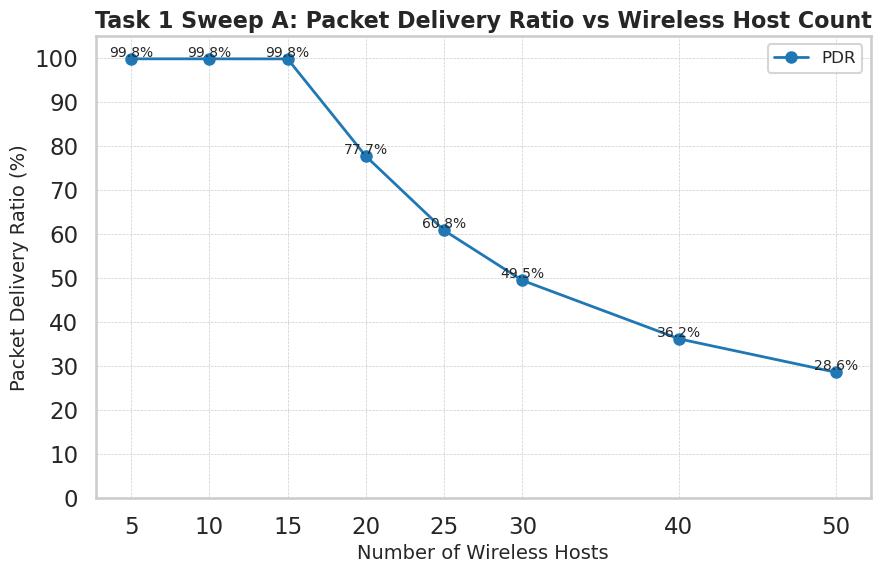

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Filter for Task 1 Sweep A ---
df_A = df[df["runName"].str.contains("T1_A")].copy()
df_A["wirelessHostCount"] = pd.to_numeric(df_A["wirelessHostCount"], errors="coerce")
df_A = df_A.sort_values(by="wirelessHostCount")

# --- Set seaborn style ---
sns.set(style="whitegrid", context="talk")  # "talk" makes fonts bigger

plt.figure(figsize=(10,6))
plt.plot(df_A["wirelessHostCount"], df_A["PDR(%)"], 
         marker="o", markersize=8, linewidth=2, linestyle='-', color='tab:blue', label="PDR")

# Optional: annotate values
for x, y in zip(df_A["wirelessHostCount"], df_A["PDR(%)"]):
    plt.text(x, y+0.5, f"{y:.1f}%", ha='center', fontsize=10)

plt.title("Task 1 Sweep A: Packet Delivery Ratio vs Wireless Host Count", fontsize=16, fontweight='bold')
plt.xlabel("Number of Wireless Hosts", fontsize=14)
plt.ylabel("Packet Delivery Ratio (%)", fontsize=14)
plt.xticks(df_A["wirelessHostCount"])  # show every host count
plt.yticks(range(0, 110, 10))
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.ylim(0, 105)
plt.legend(fontsize=12)

# --- Save figure ---
plt.savefig("Task1_SweepA_PDR.png", dpi=300, bbox_inches="tight")

plt.show()


In [31]:
print(df_A.to_latex())

\begin{tabular}{lrlrlrrrrrrrrrrrrrrrrrrrrr}
\toprule
 & runId & runName & wirelessHostCount & wiredHostCount & packetsSent & packetsReceived & packetDropped & packetReceivedByte & simTime & macFrameSent & macFrameRetransmitted & packetDroppedQueueOverflow & erroneousBits & totalBitsSent & collisionCount & PDR & PDR(%) & MAC_RetryRate & QueueOverflowRate & BER & Throughput(Mbps) & minEndToEndDelay & maxEndToEndDelay & meanEndToEndDelay & stdDevEndToEndDelay \\
\midrule
8 & 9 & T1_A_Hosts_5 & 5 & 0 & 3000.000000 & 2995.000000 & 25627.000000 & 3018960.000000 & 60 & 9986.000000 & 3296.000000 & 0.000000 & 10325568.000000 & 54099792.000000 & 1214.000000 & 0.998333 & 99.833333 & 0.330062 & 0.000000 & 0.190862 & 0.402528 & 0.007981 & 1.244917 & 0.007981 & 0.095633 \\
1 & 2 & T1_A_Hosts_10 & 10 & 0 & 6000.000000 & 5990.000000 & 114159.000000 & 6037920.000000 & 60 & 19950.000000 & 7170.000000 & 0.000000 & 60166912.000000 & 112889120.000000 & 7076.000000 & 0.998333 & 99.833333 & 0.359398 & 0.0000

In [28]:
# --- Filter for Task 1 Sweep A ---
df_A = df[df["runName"].str.contains("T1_A")].copy()
df_A["wirelessHostCount"] = pd.to_numeric(df_A["wirelessHostCount"], errors="coerce")
df_A = df_A.sort_values(by="wirelessHostCount")

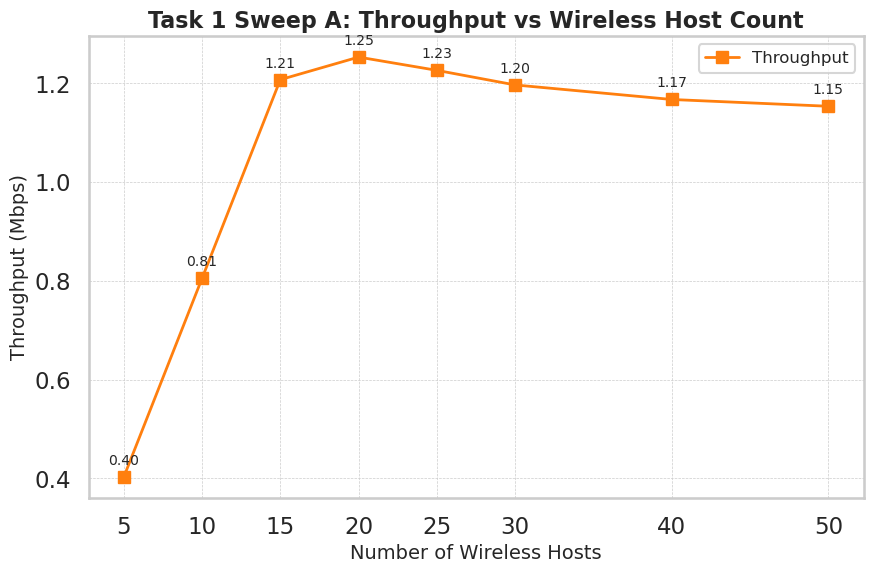

In [52]:
# --- Filter for Task 1 Sweep A ---
df_A = df[df["runName"].str.contains("T1_A")].copy()
df_A["wirelessHostCount"] = pd.to_numeric(df_A["wirelessHostCount"], errors="coerce")
df_A = df_A.sort_values(by="wirelessHostCount")

plt.figure(figsize=(10,6))
plt.plot(df_A["wirelessHostCount"], df_A["Throughput(Mbps)"], 
         marker="s", markersize=8, linewidth=2, linestyle='-', color='tab:orange', label="Throughput")

# Dynamic annotation offset: 2% of max throughput
y_offset = df_A["Throughput(Mbps)"].max() * 0.02
for x, y in zip(df_A["wirelessHostCount"], df_A["Throughput(Mbps)"]):
    plt.text(x, y + y_offset, f"{y:.2f}", ha='center', fontsize=10)

plt.title("Task 1 Sweep A: Throughput vs Wireless Host Count", fontsize=16, fontweight='bold')
plt.xlabel("Number of Wireless Hosts", fontsize=14)
plt.ylabel("Throughput (Mbps)", fontsize=14)
plt.xticks(df_A["wirelessHostCount"])
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=12)

plt.savefig("Task1_SweepA_Throughput.png", dpi=300, bbox_inches="tight")
plt.show()


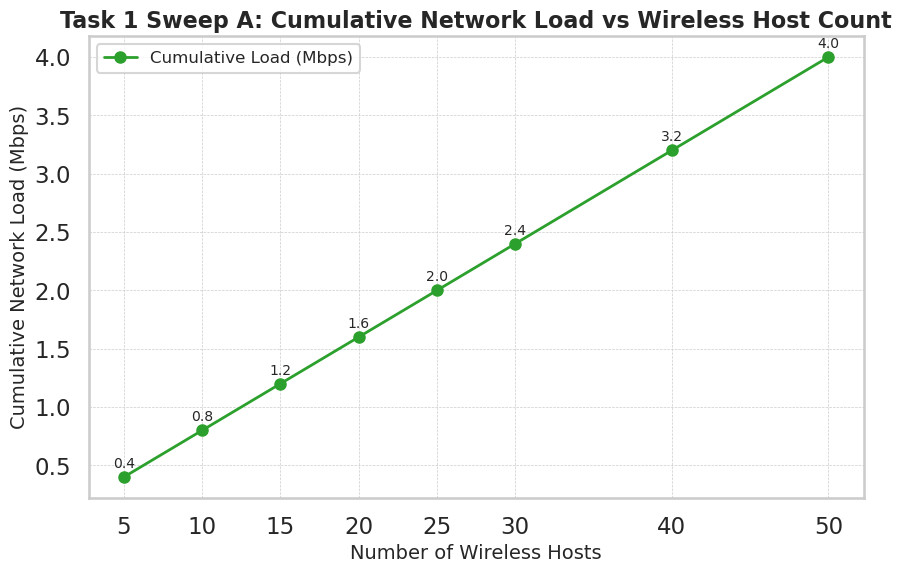

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Filter Task 1 Sweep A ---
df_A = df[df["runName"].str.contains("T1_A")].copy()

# --- Ensure wirelessHostCount is numeric ---
df_A["wirelessHostCount"] = pd.to_numeric(df_A["wirelessHostCount"], errors="coerce")

# --- Drop rows with missing wirelessHostCount ---
df_A = df_A.dropna(subset=["wirelessHostCount"])

# --- Sort by wirelessHostCount ---
df_A = df_A.sort_values(by="wirelessHostCount")

# --- Set example simulation parameters ---
# Packet Size in bytes
df_A["packetSizeByte"] = 1000  # replace with actual packet size if available
# Send Interval in seconds
df_A["sendInterval"] = 0.1  # replace with actual send interval if available

# --- Convert Packet Size to bits ---
df_A["packetSizeBit"] = df_A["packetSizeByte"] * 8

# --- Calculate Cumulative Network Load (bps) ---
df_A["CumulativeLoad_bps"] = df_A["wirelessHostCount"] * (df_A["packetSizeBit"] / df_A["sendInterval"])

# --- Plot Cumulative Load vs Wireless Hosts ---
sns.set(style="whitegrid", context="talk")
plt.figure(figsize=(10,6))

plt.plot(df_A["wirelessHostCount"], df_A["CumulativeLoad_bps"]/1e6,  # convert to Mbps
         marker="o", markersize=8, linewidth=2, linestyle='-', color='tab:green', label="Cumulative Load (Mbps)")

# Optional: annotate values
y_offset = df_A["CumulativeLoad_bps"].max() * 0.02
for x, y in zip(df_A["wirelessHostCount"], df_A["CumulativeLoad_bps"]/1e6):
    plt.text(x, y + y_offset/1e6, f"{y:.1f}", ha='center', fontsize=10)

plt.title("Task 1 Sweep A: Cumulative Network Load vs Wireless Host Count", fontsize=16, fontweight='bold')
plt.xlabel("Number of Wireless Hosts", fontsize=14)
plt.ylabel("Cumulative Network Load (Mbps)", fontsize=14)
plt.xticks(df_A["wirelessHostCount"])
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=12)

# --- Save figure ---
plt.savefig("Task1_SweepA_CumulativeLoad.png", dpi=300, bbox_inches="tight")

plt.show()


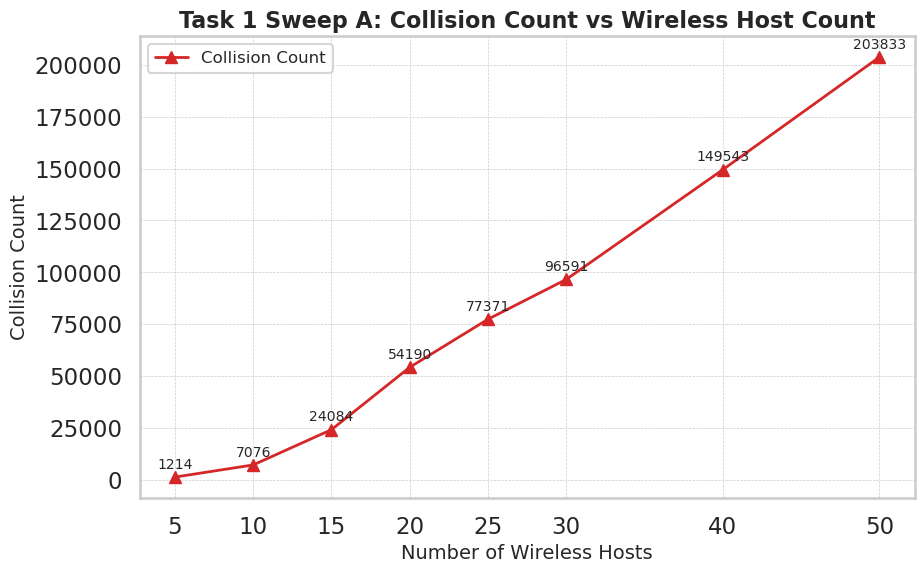

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Filter Task 1 Sweep A ---
df_A = df[df["runName"].str.contains("T1_A")].copy()

# --- Ensure wirelessHostCount and collisionCount are numeric ---
df_A["wirelessHostCount"] = pd.to_numeric(df_A["wirelessHostCount"], errors="coerce")
df_A["collisionCount"] = pd.to_numeric(df_A["collisionCount"], errors="coerce")

# --- Drop rows with missing values ---
df_A = df_A.dropna(subset=["wirelessHostCount", "collisionCount"])

# --- Sort by wirelessHostCount ---
df_A = df_A.sort_values(by="wirelessHostCount")

# --- Set seaborn style ---
sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(10,6))
plt.plot(df_A["wirelessHostCount"], df_A["collisionCount"],
         marker="^", markersize=8, linewidth=2, linestyle='-', color='tab:red', label="Collision Count")

# Optional: annotate values
y_offset = df_A["collisionCount"].max() * 0.02
for x, y in zip(df_A["wirelessHostCount"], df_A["collisionCount"]):
    plt.text(x, y + y_offset, f"{int(y)}", ha='center', fontsize=10)

plt.title("Task 1 Sweep A: Collision Count vs Wireless Host Count", fontsize=16, fontweight='bold')
plt.xlabel("Number of Wireless Hosts", fontsize=14)
plt.ylabel("Collision Count", fontsize=14)
plt.xticks(df_A["wirelessHostCount"])
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=12)

# --- Save figure ---
plt.savefig("Task1_SweepA_CollisionCount.png", dpi=300, bbox_inches="tight")

plt.show()


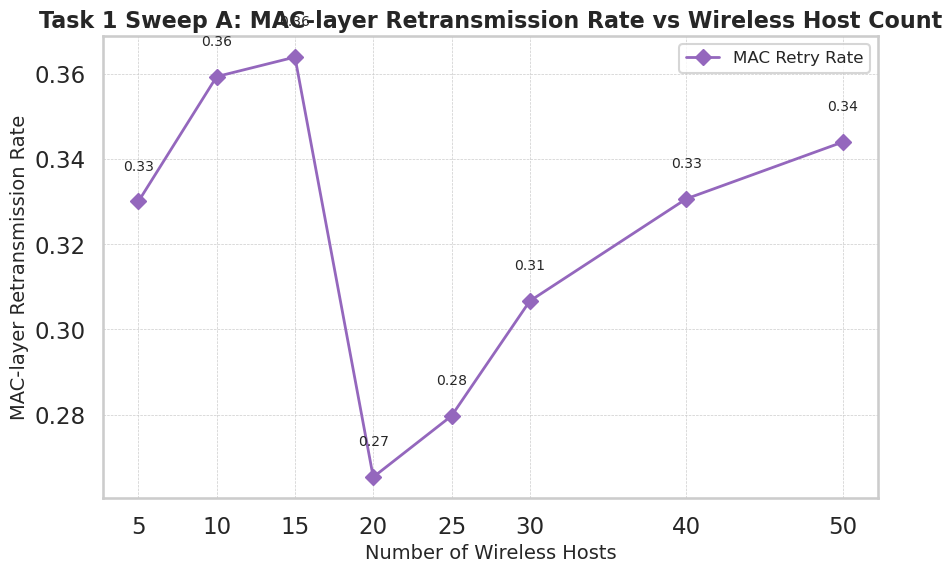

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Filter Task 1 Sweep A ---
df_A = df[df["runName"].str.contains("T1_A")].copy()

# --- Ensure wirelessHostCount and MAC_RetryRate are numeric ---
df_A["wirelessHostCount"] = pd.to_numeric(df_A["wirelessHostCount"], errors="coerce")
df_A["MAC_RetryRate"] = pd.to_numeric(df_A["MAC_RetryRate"], errors="coerce")

# --- Drop rows with missing values ---
df_A = df_A.dropna(subset=["wirelessHostCount", "MAC_RetryRate"])

# --- Sort by wirelessHostCount ---
df_A = df_A.sort_values(by="wirelessHostCount")

# --- Set seaborn style ---
sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(10,6))
plt.plot(df_A["wirelessHostCount"], df_A["MAC_RetryRate"],
         marker="D", markersize=8, linewidth=2, linestyle='-', color='tab:purple', label="MAC Retry Rate")

# Optional: annotate values
y_offset = df_A["MAC_RetryRate"].max() * 0.02
for x, y in zip(df_A["wirelessHostCount"], df_A["MAC_RetryRate"]):
    plt.text(x, y + y_offset, f"{y:.2f}", ha='center', fontsize=10)

plt.title("Task 1 Sweep A: MAC-layer Retransmission Rate vs Wireless Host Count", fontsize=16, fontweight='bold')
plt.xlabel("Number of Wireless Hosts", fontsize=14)
plt.ylabel("MAC-layer Retransmission Rate", fontsize=14)
plt.xticks(df_A["wirelessHostCount"])
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=12)

# --- Save figure ---
plt.savefig("Task1_SweepA_MAC_RetryRate.png", dpi=300, bbox_inches="tight")

plt.show()


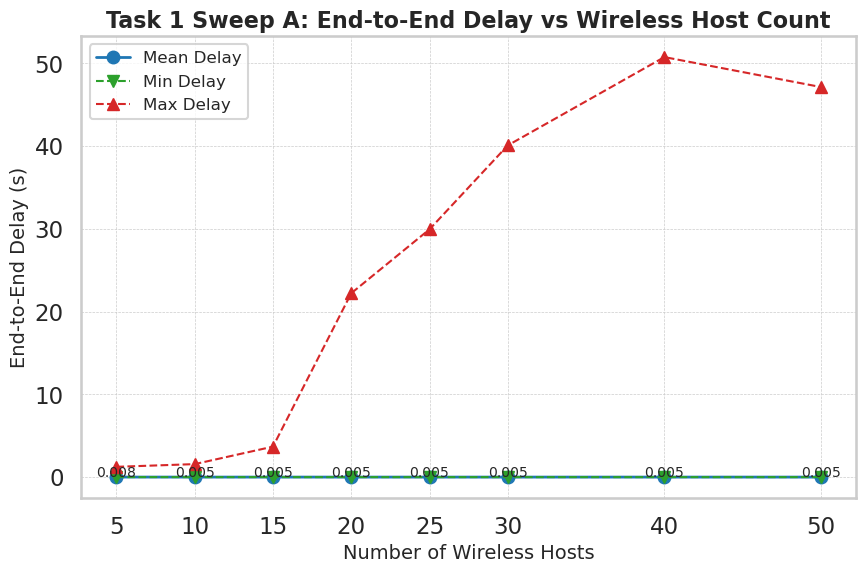

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Filter Task 1 Sweep A ---
df_A = df[df["runName"].str.contains("T1_A")].copy()
df_A["wirelessHostCount"] = pd.to_numeric(df_A["wirelessHostCount"], errors="coerce")
df_A = df_A.sort_values(by="wirelessHostCount")

# --- Set Seaborn Style ---
sns.set(style="whitegrid", context="talk")
plt.figure(figsize=(10,6))

# --- Plot mean, min, and max End-to-End Delay ---
plt.plot(df_A["wirelessHostCount"], df_A["meanEndToEndDelay"], 
         marker='o', linestyle='-', linewidth=2, label="Mean Delay", color='tab:blue')
plt.plot(df_A["wirelessHostCount"], df_A["minEndToEndDelay"], 
         marker='v', linestyle='--', linewidth=1.5, label="Min Delay", color='tab:green')
plt.plot(df_A["wirelessHostCount"], df_A["maxEndToEndDelay"], 
         marker='^', linestyle='--', linewidth=1.5, label="Max Delay", color='tab:red')

# Optional: annotate mean values
for x, y in zip(df_A["wirelessHostCount"], df_A["meanEndToEndDelay"]):
    plt.text(x, y+0.001, f"{y:.3f}", ha='center', fontsize=10)

plt.title("Task 1 Sweep A: End-to-End Delay vs Wireless Host Count", fontsize=16, fontweight='bold')
plt.xlabel("Number of Wireless Hosts", fontsize=14)
plt.ylabel("End-to-End Delay (s)", fontsize=14)
plt.xticks(df_A["wirelessHostCount"])
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=12)

# --- Save figure ---
plt.savefig("Task1_SweepA_EndToEndDelay.png", dpi=300, bbox_inches="tight")

plt.show()


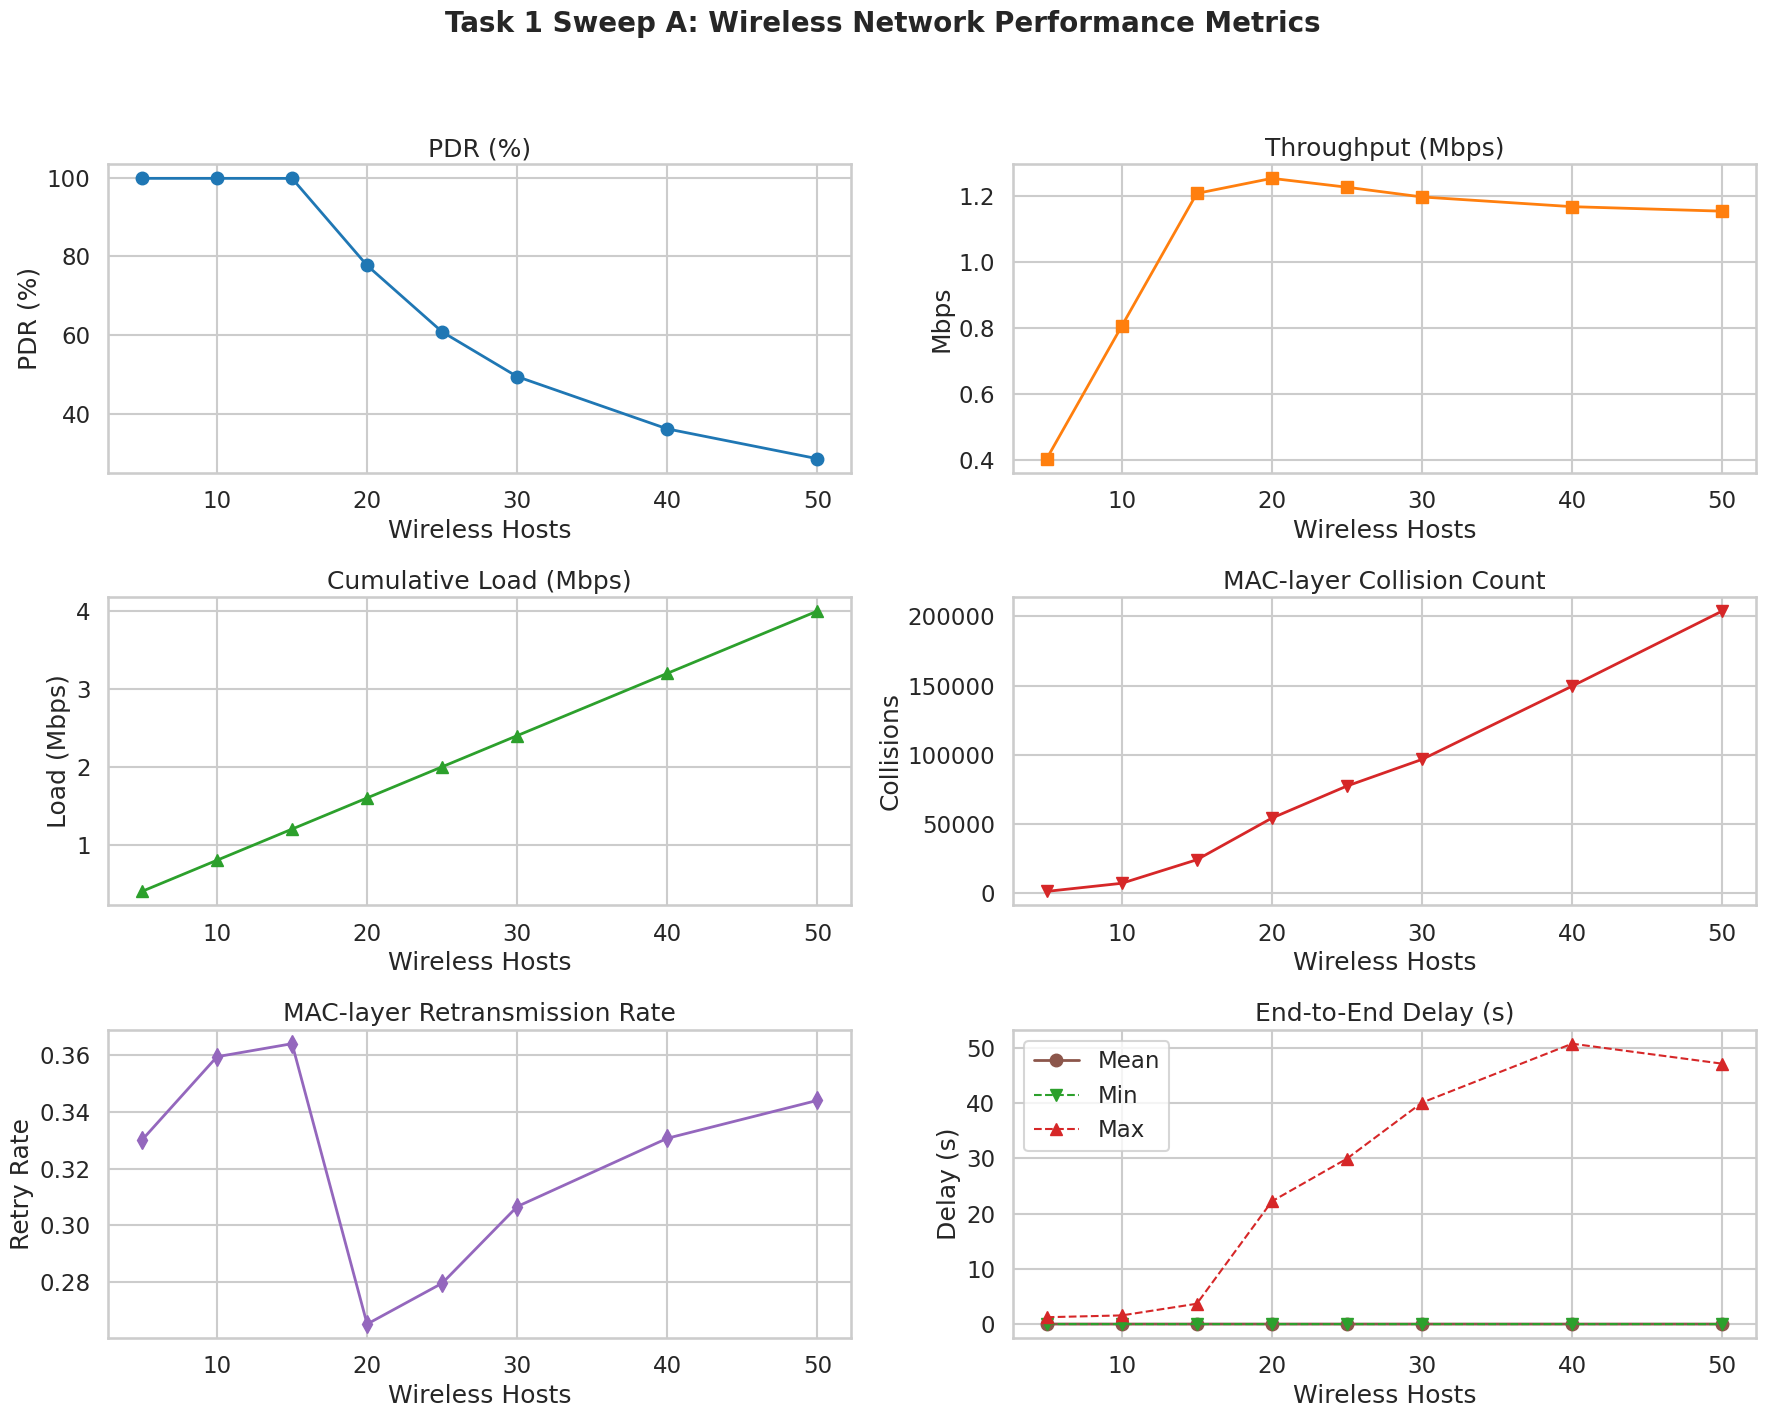

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Filter Task 1 Sweep A ---
df_A = df[df["runName"].str.contains("T1_A")].copy()
df_A["wirelessHostCount"] = pd.to_numeric(df_A["wirelessHostCount"], errors="coerce")
df_A = df_A.sort_values(by="wirelessHostCount")

# --- Example parameters for Cumulative Load and Throughput ---
df_A["packetSizeByte"] = 1000      # Replace with actual packet size if available
df_A["sendInterval"] = 0.1         # Replace with actual send interval in seconds

# Convert Packet Size to bits
df_A["packetSizeBit"] = df_A["packetSizeByte"] * 8

# Cumulative Load (bps)
df_A["CumulativeLoad_bps"] = df_A["wirelessHostCount"] * (df_A["packetSizeBit"] / df_A["sendInterval"])

# Throughput (Mbps)
df_A["Throughput(Mbps)"] = (df_A["packetReceivedByte"] * 8) / (df_A["simTime"] * 1e6)

# Set seaborn style
sns.set(style="whitegrid", context="talk")

# --- Create figure with 3x2 subplots ---
fig, axes = plt.subplots(3, 2, figsize=(18, 15))
axes = axes.flatten()

# 1. Packet Delivery Ratio
axes[0].plot(df_A["wirelessHostCount"], df_A["PDR(%)"], marker='o', color='tab:blue', linewidth=2)
axes[0].set_title("PDR (%)")
axes[0].set_xlabel("Wireless Hosts")
axes[0].set_ylabel("PDR (%)")
axes[0].grid(True)

# 2. Throughput
axes[1].plot(df_A["wirelessHostCount"], df_A["Throughput(Mbps)"], marker='s', color='tab:orange', linewidth=2)
axes[1].set_title("Throughput (Mbps)")
axes[1].set_xlabel("Wireless Hosts")
axes[1].set_ylabel("Mbps")
axes[1].grid(True)

# 3. Cumulative Network Load
axes[2].plot(df_A["wirelessHostCount"], df_A["CumulativeLoad_bps"]/1e6, marker='^', color='tab:green', linewidth=2)
axes[2].set_title("Cumulative Load (Mbps)")
axes[2].set_xlabel("Wireless Hosts")
axes[2].set_ylabel("Load (Mbps)")
axes[2].grid(True)

# 4. Collision Count
axes[3].plot(df_A["wirelessHostCount"], df_A["collisionCount"], marker='v', color='tab:red', linewidth=2)
axes[3].set_title("MAC-layer Collision Count")
axes[3].set_xlabel("Wireless Hosts")
axes[3].set_ylabel("Collisions")
axes[3].grid(True)

# 5. MAC-layer Retransmission Rate
axes[4].plot(df_A["wirelessHostCount"], df_A["MAC_RetryRate"], marker='d', color='tab:purple', linewidth=2)
axes[4].set_title("MAC-layer Retransmission Rate")
axes[4].set_xlabel("Wireless Hosts")
axes[4].set_ylabel("Retry Rate")
axes[4].grid(True)

# 6. End-to-End Delay
axes[5].plot(df_A["wirelessHostCount"], df_A["meanEndToEndDelay"], marker='o', color='tab:brown', linewidth=2, label='Mean')
axes[5].plot(df_A["wirelessHostCount"], df_A["minEndToEndDelay"], marker='v', linestyle='--', color='tab:green', linewidth=1.5, label='Min')
axes[5].plot(df_A["wirelessHostCount"], df_A["maxEndToEndDelay"], marker='^', linestyle='--', color='tab:red', linewidth=1.5, label='Max')
axes[5].set_title("End-to-End Delay (s)")
axes[5].set_xlabel("Wireless Hosts")
axes[5].set_ylabel("Delay (s)")
axes[5].grid(True)
axes[5].legend()

plt.suptitle("Task 1 Sweep A: Wireless Network Performance Metrics", fontsize=20, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# --- Save figure ---
plt.savefig("Task1_SweepA_AllMetrics.png", dpi=300, bbox_inches="tight")
plt.show()


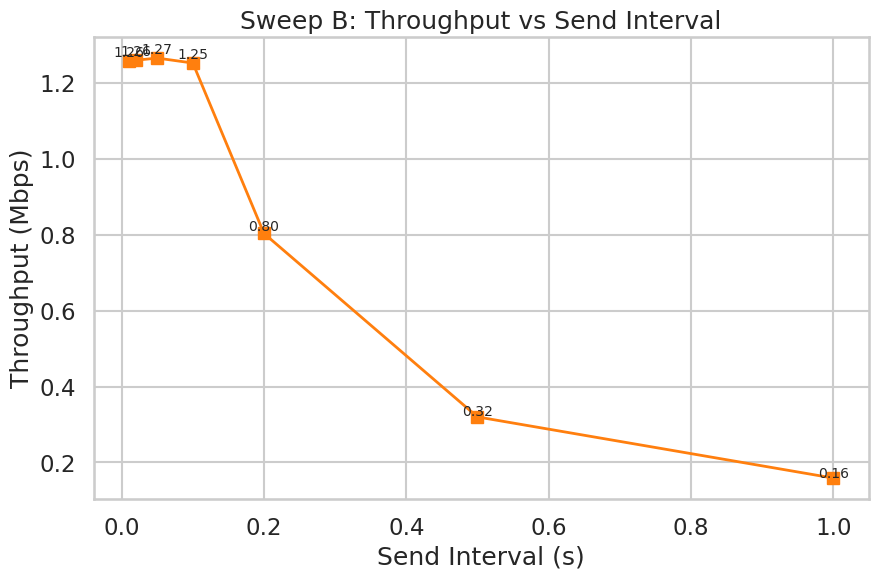

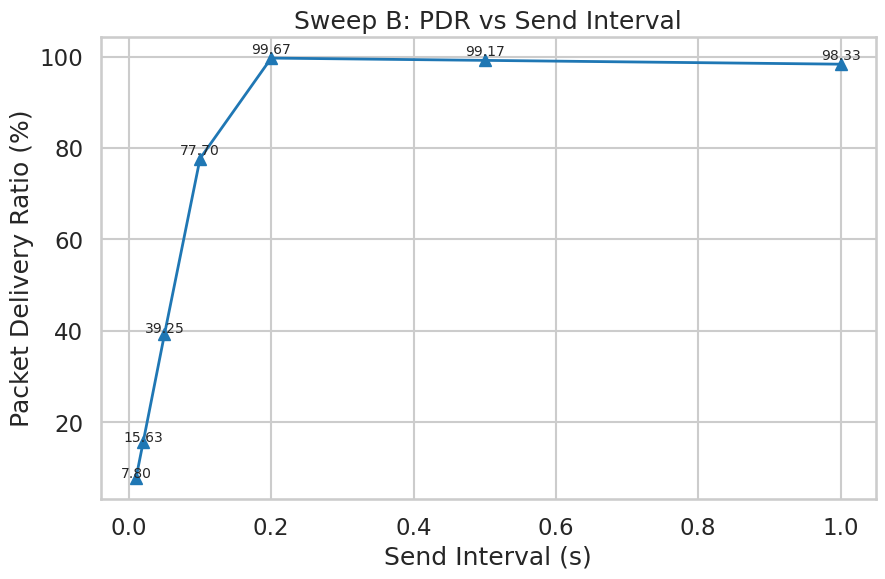

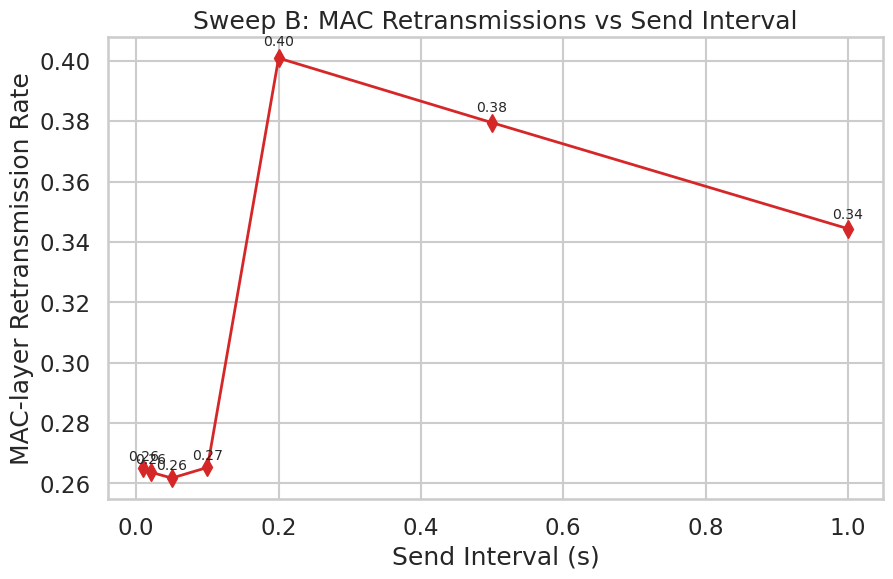

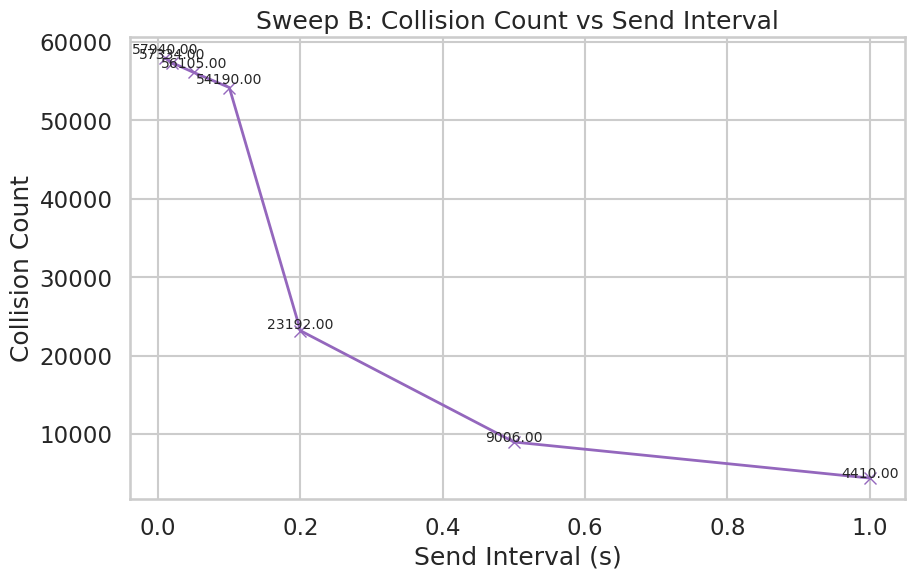

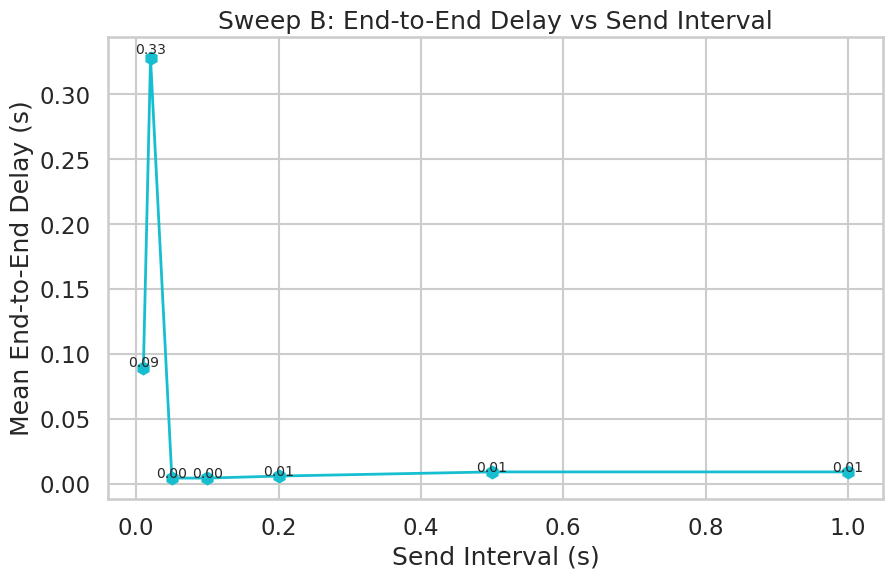

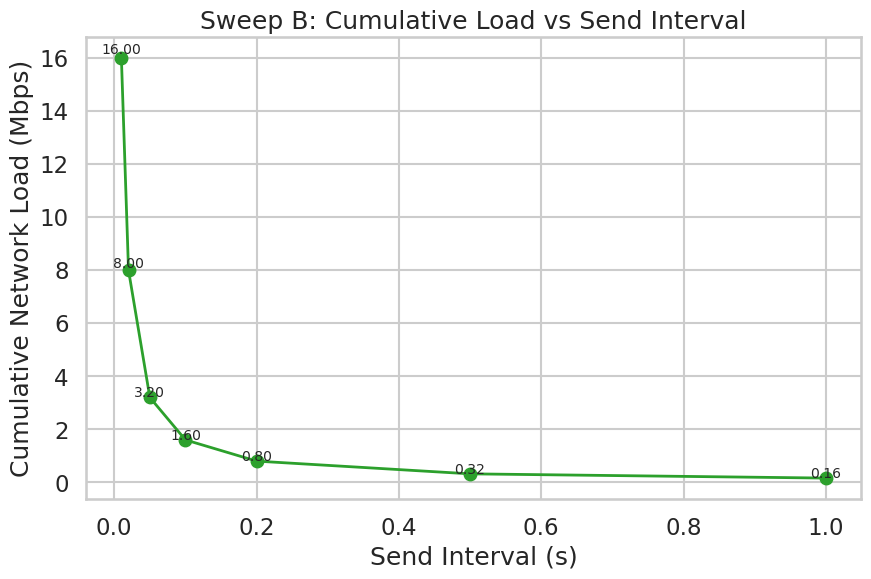

In [72]:
# --- Filter Sweep B ---
df_B = df[df["runName"].str.contains("T1_B")].copy()

# --- Extract numeric sendInterval in seconds from runName ---
def extract_send_interval(run_name):
    match = re.search(r'Load_([0-9p]+)s', run_name)
    if match:
        val_str = match.group(1)
        return float(val_str.replace('p','.'))
    return None

df_B["sendInterval"] = df_B["runName"].apply(extract_send_interval)
df_B = df_B.dropna(subset=["sendInterval"])

# --- Sort ascending by sendInterval (high load left) ---
df_B = df_B.sort_values(by="sendInterval", ascending=True)

# --- Constants ---
df_B["packetSizeByte"] = 1000        # packet size
df_B["packetSizeBit"] = df_B["packetSizeByte"] * 8
df_B["numHosts"] = 20                # fixed host count

# --- Cumulative Network Load (bps & Mbps) ---
df_B["CumulativeLoad_bps"] = df_B["numHosts"] * (df_B["packetSizeBit"] / df_B["sendInterval"])
df_B["CumulativeLoad_Mbps"] = df_B["CumulativeLoad_bps"] / 1e6

# --- Throughput (Mbps) ---
df_B["Throughput_Mbps"] = (df_B["packetReceivedByte"] * 8) / (df_B["simTime"] * 1e6)

# --- PDR (%) ---
df_B["PDR(%)"] = (df_B["packetsReceived"] / df_B["packetsSent"]) * 100

# --- MAC-layer Retransmission Rate ---
df_B["MAC_RetryRate"] = df_B["macFrameRetransmitted"] / df_B["macFrameSent"]

# --- Collision Count ---
df_B["collisionCount"] = df_B["collisionCount"]

# --- End-to-End Delay (mean) ---
df_B["meanEndToEndDelay"] = df_B["meanEndToEndDelay"]

# --- Seaborn styling ---
sns.set(style="whitegrid", context="talk")

# --- Helper function to plot with annotation ---
def plot_with_annotation(x, y, xlabel, ylabel, title, filename, marker='o', color='tab:blue'):
    plt.figure(figsize=(10,6))
    plt.plot(x, y, marker=marker, color=color, linewidth=2)
    for xi, yi in zip(x, y):
        plt.text(xi, yi*1.01, f"{yi:.2f}", ha='center', fontsize=10)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

# --- Plots ---
plot_with_annotation(df_B["sendInterval"], df_B["Throughput_Mbps"],
                     "Send Interval (s)", "Throughput (Mbps)",
                     "Sweep B: Throughput vs Send Interval",
                     "SweepB_Throughput_vs_SendInterval.png",
                     marker='s', color='tab:orange')

plot_with_annotation(df_B["sendInterval"], df_B["PDR(%)"],
                     "Send Interval (s)", "Packet Delivery Ratio (%)",
                     "Sweep B: PDR vs Send Interval",
                     "SweepB_PDR_vs_SendInterval.png",
                     marker='^', color='tab:blue')

plot_with_annotation(df_B["sendInterval"], df_B["MAC_RetryRate"],
                     "Send Interval (s)", "MAC-layer Retransmission Rate",
                     "Sweep B: MAC Retransmissions vs Send Interval",
                     "SweepB_MAC_Retransmission_vs_SendInterval.png",
                     marker='d', color='tab:red')

plot_with_annotation(df_B["sendInterval"], df_B["collisionCount"],
                     "Send Interval (s)", "Collision Count",
                     "Sweep B: Collision Count vs Send Interval",
                     "SweepB_CollisionCount_vs_SendInterval.png",
                     marker='x', color='tab:purple')

plot_with_annotation(df_B["sendInterval"], df_B["meanEndToEndDelay"],
                     "Send Interval (s)", "Mean End-to-End Delay (s)",
                     "Sweep B: End-to-End Delay vs Send Interval",
                     "SweepB_EndToEndDelay_vs_SendInterval.png",
                     marker='h', color='tab:cyan')

plot_with_annotation(df_B["sendInterval"], df_B["CumulativeLoad_Mbps"],
                     "Send Interval (s)", "Cumulative Network Load (Mbps)",
                     "Sweep B: Cumulative Load vs Send Interval",
                     "SweepB_CumulativeLoad_vs_SendInterval.png",
                     marker='o', color='tab:green')


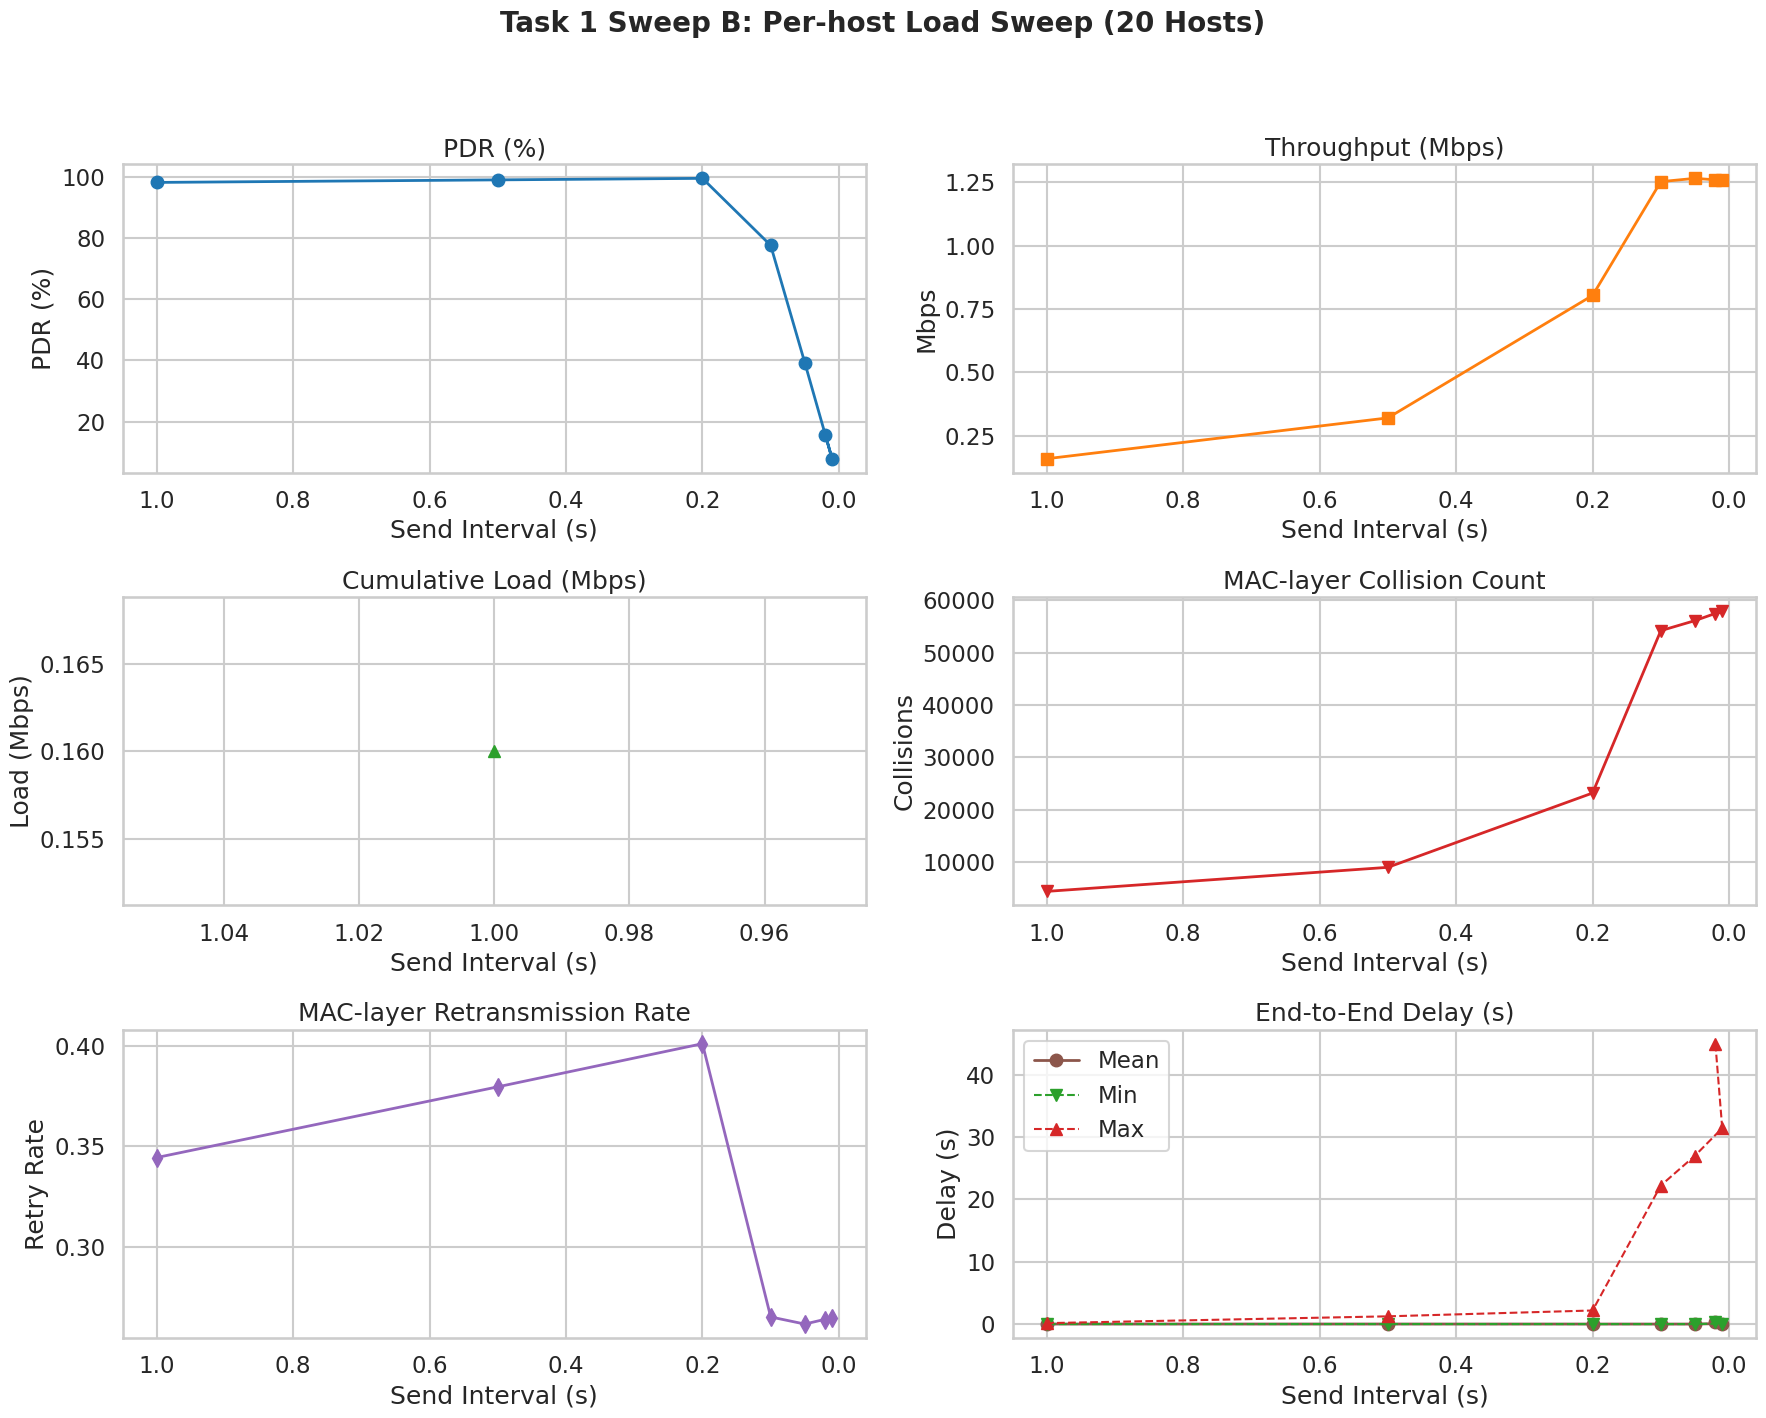

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Filter Task 1 Sweep B ---
df_B = df[df["runName"].str.contains("T1_B")].copy()
df_B["wirelessHostCount"] = pd.to_numeric(df_B["wirelessHostCount"], errors="coerce")

# --- Extract sendInterval from runName if needed ---
# Since sendInterval is encoded in seconds in the config name, we can parse it
def parse_send_interval(name):
    if "0p01" in name:
        return 0.01
    elif "0p02" in name:
        return 0.02
    elif "0p05" in name:
        return 0.05
    elif "0p1" in name:
        return 0.1
    elif "0p2" in name:
        return 0.2
    elif "0p5" in name:
        return 0.5
    elif "1s" in name:
        return 1.0
    else:
        return 1.0  # default

df_B["sendInterval"] = df_B["runName"].apply(parse_send_interval)

# --- Example Packet Size (replace with actual if available) ---
df_B["packetSizeByte"] = 1000
df_B["packetSizeBit"] = df_B["packetSizeByte"] * 8

# --- Cumulative Network Load (bps) ---
df_B["CumulativeLoad_bps"] = df_B["wirelessHostCount"] * (df_B["packetSizeBit"] / df_B["sendInterval"])

# --- Throughput (Mbps) ---
df_B["Throughput(Mbps)"] = (df_B["packetReceivedByte"] * 8) / (df_B["simTime"] * 1e6)

# --- Set seaborn style ---
sns.set(style="whitegrid", context="talk")

# --- Create figure with 3x2 subplots ---
fig, axes = plt.subplots(3, 2, figsize=(18, 15))
axes = axes.flatten()

# 1. Packet Delivery Ratio
axes[0].plot(df_B["sendInterval"], df_B["PDR(%)"], marker='o', color='tab:blue', linewidth=2)
axes[0].set_title("PDR (%)")
axes[0].set_xlabel("Send Interval (s)")
axes[0].set_ylabel("PDR (%)")
axes[0].invert_xaxis()  # Smaller interval = higher load
axes[0].grid(True)

# 2. Throughput
axes[1].plot(df_B["sendInterval"], df_B["Throughput(Mbps)"], marker='s', color='tab:orange', linewidth=2)
axes[1].set_title("Throughput (Mbps)")
axes[1].set_xlabel("Send Interval (s)")
axes[1].set_ylabel("Mbps")
axes[1].invert_xaxis()
axes[1].grid(True)

# 3. Cumulative Network Load
axes[2].plot(df_B["sendInterval"], df_B["CumulativeLoad_bps"]/1e6, marker='^', color='tab:green', linewidth=2)
axes[2].set_title("Cumulative Load (Mbps)")
axes[2].set_xlabel("Send Interval (s)")
axes[2].set_ylabel("Load (Mbps)")
axes[2].invert_xaxis()
axes[2].grid(True)

# 4. Collision Count
axes[3].plot(df_B["sendInterval"], df_B["collisionCount"], marker='v', color='tab:red', linewidth=2)
axes[3].set_title("MAC-layer Collision Count")
axes[3].set_xlabel("Send Interval (s)")
axes[3].set_ylabel("Collisions")
axes[3].invert_xaxis()
axes[3].grid(True)

# 5. MAC-layer Retransmission Rate
axes[4].plot(df_B["sendInterval"], df_B["MAC_RetryRate"], marker='d', color='tab:purple', linewidth=2)
axes[4].set_title("MAC-layer Retransmission Rate")
axes[4].set_xlabel("Send Interval (s)")
axes[4].set_ylabel("Retry Rate")
axes[4].invert_xaxis()
axes[4].grid(True)

# 6. End-to-End Delay
axes[5].plot(df_B["sendInterval"], df_B["meanEndToEndDelay"], marker='o', color='tab:brown', linewidth=2, label='Mean')
axes[5].plot(df_B["sendInterval"], df_B["minEndToEndDelay"], marker='v', linestyle='--', color='tab:green', linewidth=1.5, label='Min')
axes[5].plot(df_B["sendInterval"], df_B["maxEndToEndDelay"], marker='^', linestyle='--', color='tab:red', linewidth=1.5, label='Max')
axes[5].set_title("End-to-End Delay (s)")
axes[5].set_xlabel("Send Interval (s)")
axes[5].set_ylabel("Delay (s)")
axes[5].invert_xaxis()
axes[5].grid(True)
axes[5].legend()

plt.suptitle("Task 1 Sweep B: Per-host Load Sweep (20 Hosts)", fontsize=20, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# --- Save figure ---
plt.savefig("Task1_SweepB_AllMetrics.png", dpi=300, bbox_inches="tight")
plt.show()


KeyError: 'pdr'

<Figure size 1000x600 with 0 Axes>

In [84]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted", font_scale=1.1)

output_folder = "task2"
os.makedirs(output_folder, exist_ok=True)

# General plotting function
def plot_metric(df, x_col, metric_col, ylabel, title, filename, hue_col=None):
    plt.figure(figsize=(8,6))
    sns.lineplot(
        data=df,
        x=x_col,
        y=metric_col,
        hue=hue_col,
        marker='o',
        linewidth=2,
        markersize=8
    )
    plt.xlabel(x_col)
    plt.ylabel(ylabel)
    plt.title(title)
    if hue_col:
        plt.legend(title=hue_col)
    plt.tight_layout()
    filepath = os.path.join(output_folder, filename)
    plt.savefig(filepath, dpi=300)
    plt.close()
    print(f"Saved: {filepath}")

# -----------------------------
# 1. Host Count Sweep (T2_A)
# -----------------------------
plot_metric(df, 'wirelessHostCount', 'QueueOverflowRate', 'Queue Overflow Rate', 'Queue Overflow vs Host Count', 'T2A_QueueOverflow_vs_HostCount.png')
plot_metric(df, 'wirelessHostCount', 'PDR(%)', 'Packet Delivery Ratio (%)', 'PDR vs Host Count', 'T2A_PDR_vs_HostCount.png')
plot_metric(df, 'wirelessHostCount', 'Throughput(Mbps)', 'Throughput (Mbps)', 'Throughput vs Host Count', 'T2A_Throughput_vs_HostCount.png')
plot_metric(df, 'wirelessHostCount', 'meanEndToEndDelay', 'Mean End-to-End Delay (s)', 'End-to-End Delay vs Host Count', 'T2A_Delay_vs_HostCount.png')

# -----------------------------
# 2. Traffic Intensity Sweep (T2_B)
# -----------------------------
plot_metric(df, 'sendInterval', 'QueueOverflowRate', 'Queue Overflow Rate', 'Queue Overflow vs Send Interval', 'T2B_QueueOverflow_vs_SendInterval.png')
plot_metric(df, 'sendInterval', 'PDR(%)', 'Packet Delivery Ratio (%)', 'PDR vs Send Interval', 'T2B_PDR_vs_SendInterval.png')
plot_metric(df, 'sendInterval', 'Throughput(Mbps)', 'Throughput (Mbps)', 'Throughput vs Send Interval', 'T2B_Throughput_vs_SendInterval.png')
plot_metric(df, 'sendInterval', 'meanEndToEndDelay', 'Mean End-to-End Delay (s)', 'End-to-End Delay vs Send Interval', 'T2B_Delay_vs_SendInterval.png')

# -----------------------------
# 3. DCF Aggressiveness Sweep (T2_C)
# -----------------------------
plot_metric(df, 'macFrameRetransmitted', 'QueueOverflowRate', 'Queue Overflow Rate', 'Queue Overflow vs CWmin (approximated by MAC Retries)', 'T2C_QueueOverflow_vs_CWmin.png')
plot_metric(df, 'macFrameRetransmitted', 'PDR(%)', 'Packet Delivery Ratio (%)', 'PDR vs CWmin', 'T2C_PDR_vs_CWmin.png')
plot_metric(df, 'macFrameRetransmitted', 'Throughput(Mbps)', 'Throughput (Mbps)', 'Throughput vs CWmin', 'T2C_Throughput_vs_CWmin.png')
plot_metric(df, 'macFrameRetransmitted', 'meanEndToEndDelay', 'Mean End-to-End Delay (s)', 'End-to-End Delay vs CWmin', 'T2C_Delay_vs_CWmin.png')


Saved: task2/T2A_QueueOverflow_vs_HostCount.png
Saved: task2/T2A_PDR_vs_HostCount.png
Saved: task2/T2A_Throughput_vs_HostCount.png
Saved: task2/T2A_Delay_vs_HostCount.png
Saved: task2/T2B_QueueOverflow_vs_SendInterval.png
Saved: task2/T2B_PDR_vs_SendInterval.png
Saved: task2/T2B_Throughput_vs_SendInterval.png
Saved: task2/T2B_Delay_vs_SendInterval.png
Saved: task2/T2C_QueueOverflow_vs_CWmin.png
Saved: task2/T2C_PDR_vs_CWmin.png
Saved: task2/T2C_Throughput_vs_CWmin.png
Saved: task2/T2C_Delay_vs_CWmin.png


In [95]:
import matplotlib.pyplot as plt
import pandas as pd

# Load your results
df = pd.read_csv("task4_results.csv")

# Define metrics for Task 4
metrics = {
    "PDR(%)": "Packet Delivery Ratio (%)",
    "Throughput(Mbps)": "Throughput (Mbps)",
    "collisionCount": "Collision Count",
    "MAC_RetryRate": "MAC Retry Rate",
    "meanEndToEndDelay": "Mean End-to-End Delay (s)",
    "BER": "Bit Error Rate",
    "SNR": "Signal-to-Noise Ratio (dB)"
}

# Make plots
for metric, label in metrics.items():
    plt.figure(figsize=(9, 6))

    # Separate wired and wireless data
    wireless = df[df["Segment"] == "Wireless"]
    wired = df[df["Segment"] == "Wired"]

    # Bar plot side by side
    x = range(len(wireless))
    bar_width = 0.35

    plt.bar(
        [i - bar_width/2 for i in x],
        wireless[metric],
        width=bar_width,
        label="Wireless",
        color="tab:red",
        alpha=0.8
    )

    plt.bar(
        [i + bar_width/2 for i in x],
        wired[metric],
        width=bar_width,
        label="Wired",
        color="tab:blue",
        alpha=0.8
    )

    # Add value annotations
    for i, v in enumerate(wireless[metric]):
        plt.text(i - bar_width/2, v + (0.02 * v if v != 0 else 0.01), f"{v:.2f}", 
                 ha="center", va="bottom", fontsize=9)

    for i, v in enumerate(wired[metric]):
        plt.text(i + bar_width/2, v + (0.02 * v if v != 0 else 0.01), f"{v:.2f}", 
                 ha="center", va="bottom", fontsize=9)

    # Labels and legend
    plt.xlabel("Run Index", fontsize=12)
    plt.ylabel(label, fontsize=12)
    plt.title(f"Comparison of Wired vs Wireless under Saturation\n({label})", fontsize=14, pad=15)
    plt.xticks(x, [f"Run {i+1}" for i in x])
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.savefig(f"task4_{metric}.png", dpi=300)
    plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'task4_results.csv'

In [32]:
# Assuming your full DataFrame is `df`
# Filter columns relevant for Task 1
task1_cols = [
    'runId', 'runName', 'wirelessHostCount', 'wiredHostCount',
    'packetsSent', 'packetsReceived', 'packetDropped',
    'PDR(%)', 'Throughput(Mbps)', 'meanEndToEndDelay', 'collisionCount', 'MAC_RetryRate'
]

# Keep only columns that actually exist in the DataFrame
task1_cols = [c for c in task1_cols if c in df.columns]

# Filtered DataFrame
df_task1 = df[task1_cols]

# Export to CSV
df_task1.to_csv("task1_filtered.csv", index=False)

print("Task 1 filtered CSV saved as task1_filtered.csv")

Task 1 filtered CSV saved as task1_filtered.csv


In [33]:
import pandas as pd

# Define relevant columns for Task 2
task2_cols = [
    'runId', 'runName', 'packetsSent', 'packetsReceived', 'packetDropped',
    'PDR(%)', 'Throughput(Mbps)', 'meanEndToEndDelay', 
    'collisionCount', 'MAC_RetryRate', 'QueueOverflowRate'
]

# Keep only columns that actually exist in the DataFrame
task2_cols = [c for c in task2_cols if c in df.columns]

# Filtered DataFrame
df_task2 = df[task2_cols]

# Export to CSV
df_task2.to_csv("task2_filtered.csv", index=False)

print("Task 2 filtered CSV saved as task2_filtered.csv")


Task 2 filtered CSV saved as task2_filtered.csv


In [34]:
import pandas as pd

# Define relevant columns for Task 3
task3_cols = [
    'runId', 'runName', 'packetsSent', 'packetsReceived', 'packetDropped',
    'PDR(%)', 'Throughput(Mbps)', 'meanEndToEndDelay', 
    'collisionCount', 'MAC_RetryRate', 'QueueOverflowRate', 'BER', 'SNR'
]

# Keep only the columns that actually exist in the DataFrame
task3_cols = [c for c in task3_cols if c in df.columns]

# Filter the DataFrame for Task 3 runs
df_task3 = df[df['runName'].str.contains("T3_")][task3_cols]

# Export filtered Task 3 CSV
df_task3.to_csv("task3_filtered.csv", index=False)

print("Task 3 filtered CSV saved as task3_filtered.csv")


Task 3 filtered CSV saved as task3_filtered.csv


In [35]:
import pandas as pd

# Define relevant columns for Task 4
task4_cols = [
    'runId', 'runName', 'packetsSent', 'packetsReceived', 'packetDropped',
    'PDR(%)', 'Throughput(Mbps)', 'meanEndToEndDelay',
    'collisionCount', 'MAC_RetryRate', 'QueueOverflowRate', 'BER', 'SNR'
]

# Keep only columns that exist in the DataFrame
task4_cols = [c for c in task4_cols if c in df.columns]

# Filter the DataFrame for Task 4 runs
df_task4 = df[df['runName'].str.contains("T4_")][task4_cols]

# Export filtered Task 4 CSV
df_task4.to_csv("task4_filtered.csv", index=False)

print("Task 4 filtered CSV saved as task4_filtered.csv")


Task 4 filtered CSV saved as task4_filtered.csv
